### Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Import data

In [2]:
# Read the CSV file into a DataFrame
df = pd.read_csv('../data/raw/Base.csv')

# Convert the variables to the appropriate data types
df['fraud_bool'] = df['fraud_bool'].astype('category')
df['payment_type'] = df['payment_type'].astype('category')
df['employment_status'] = df['employment_status'].astype('category')
df['email_is_free'] = df['email_is_free'].astype('uint8')
df['housing_status'] = df['housing_status'].astype('category')
df['phone_home_valid'] = df['phone_home_valid'].astype('uint8')
df['phone_mobile_valid'] = df['phone_mobile_valid'].astype('uint8')
df['has_other_cards'] = df['has_other_cards'].astype('uint8')
df['foreign_request'] = df['foreign_request'].astype('uint8')
df['source'] = df['source'].astype('category')
df['device_os'] = df['device_os'].astype('category')

### Initial Exploration

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype   
---  ------                            --------------    -----   
 0   fraud_bool                        1000000 non-null  category
 1   income                            1000000 non-null  float64 
 2   name_email_similarity             1000000 non-null  float64 
 3   prev_address_months_count         1000000 non-null  int64   
 4   current_address_months_count      1000000 non-null  int64   
 5   customer_age                      1000000 non-null  int64   
 6   days_since_request                1000000 non-null  float64 
 7   intended_balcon_amount            1000000 non-null  float64 
 8   payment_type                      1000000 non-null  category
 9   zip_count_4w                      1000000 non-null  int64   
 10  velocity_6h                       1000000 non-null  float64 
 11  velocity_24h             

In [4]:
print(df.describe(include='all'))

        fraud_bool          income  name_email_similarity  \
count    1000000.0  1000000.000000         1000000.000000   
unique         2.0             NaN                    NaN   
top            0.0             NaN                    NaN   
freq      988971.0             NaN                    NaN   
mean           NaN        0.562696               0.493694   
std            NaN        0.290343               0.289125   
min            NaN        0.100000               0.000001   
25%            NaN        0.300000               0.225216   
50%            NaN        0.600000               0.492153   
75%            NaN        0.800000               0.755567   
max            NaN        0.900000               0.999999   

        prev_address_months_count  current_address_months_count  \
count              1000000.000000                1000000.000000   
unique                        NaN                           NaN   
top                           NaN                           NaN   

#### General data distribution (For numerical variables)

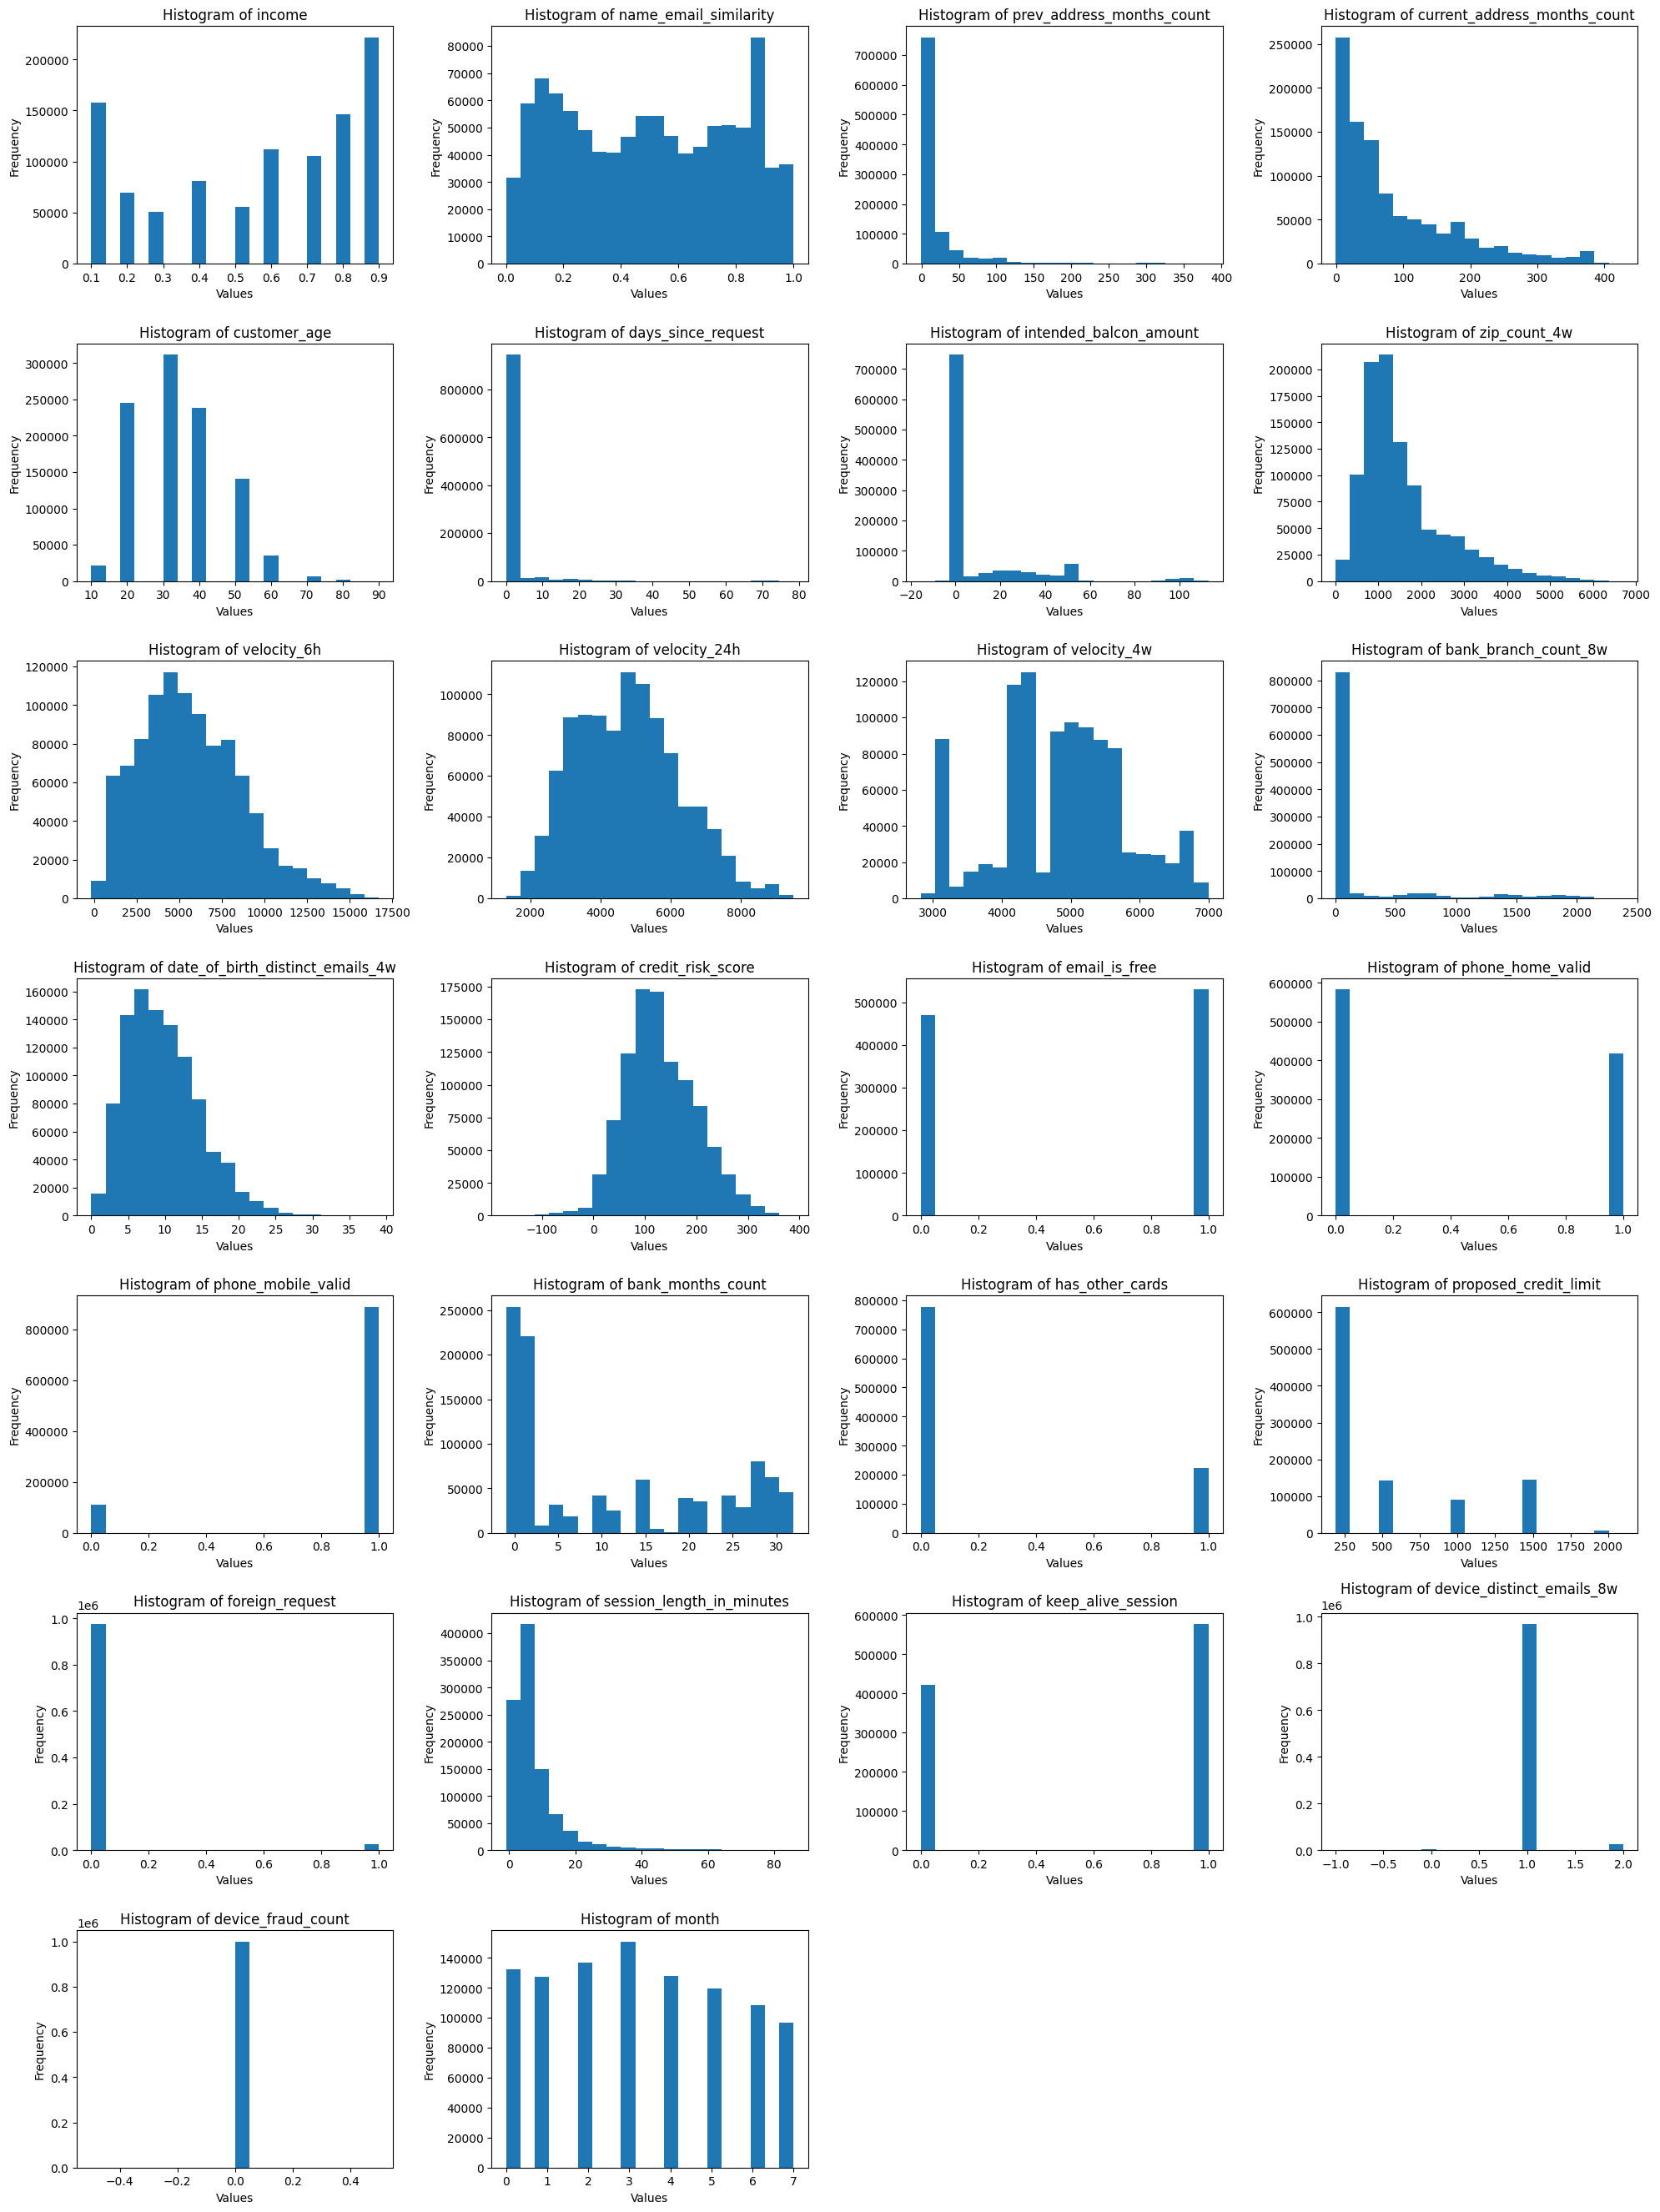

In [5]:
non_categorical_df = df.select_dtypes(exclude=['category'])

num_cols = len(non_categorical_df.columns)
num_rows = 8  # Number of rows in the grid
num_cols_per_row = 4  # Number of columns per row

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols_per_row, figsize=(20, 30))

# Flatten the axes array to easily access each subplot
axes = axes.flatten()

# Loop through each column and plot its histogram on a separate subplot
for i, column_name in enumerate(non_categorical_df.columns):
    row_index = i // num_cols_per_row
    col_index = i % num_cols_per_row
    non_categorical_df[column_name].plot(kind='hist', ax=axes[i], bins=20)
    axes[i].set_title('Histogram of {}'.format(column_name))
    axes[i].set_xlabel('Values')
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots
for j in range(num_cols, num_rows * num_cols_per_row):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap of titles
plt.tight_layout()

# Display the plot
plt.show()

#### Label-wise data distribution (For numerical variables)

In [6]:
categorical_df = df.select_dtypes(include=['category'])

non_categorical_label_df = non_categorical_df
non_categorical_label_df['fraud_bool'] = df['fraud_bool']

non_categorical_fraud = non_categorical_label_df[non_categorical_label_df['fraud_bool'] == 1]
non_categorical_real = non_categorical_label_df[non_categorical_label_df['fraud_bool'] == 0]

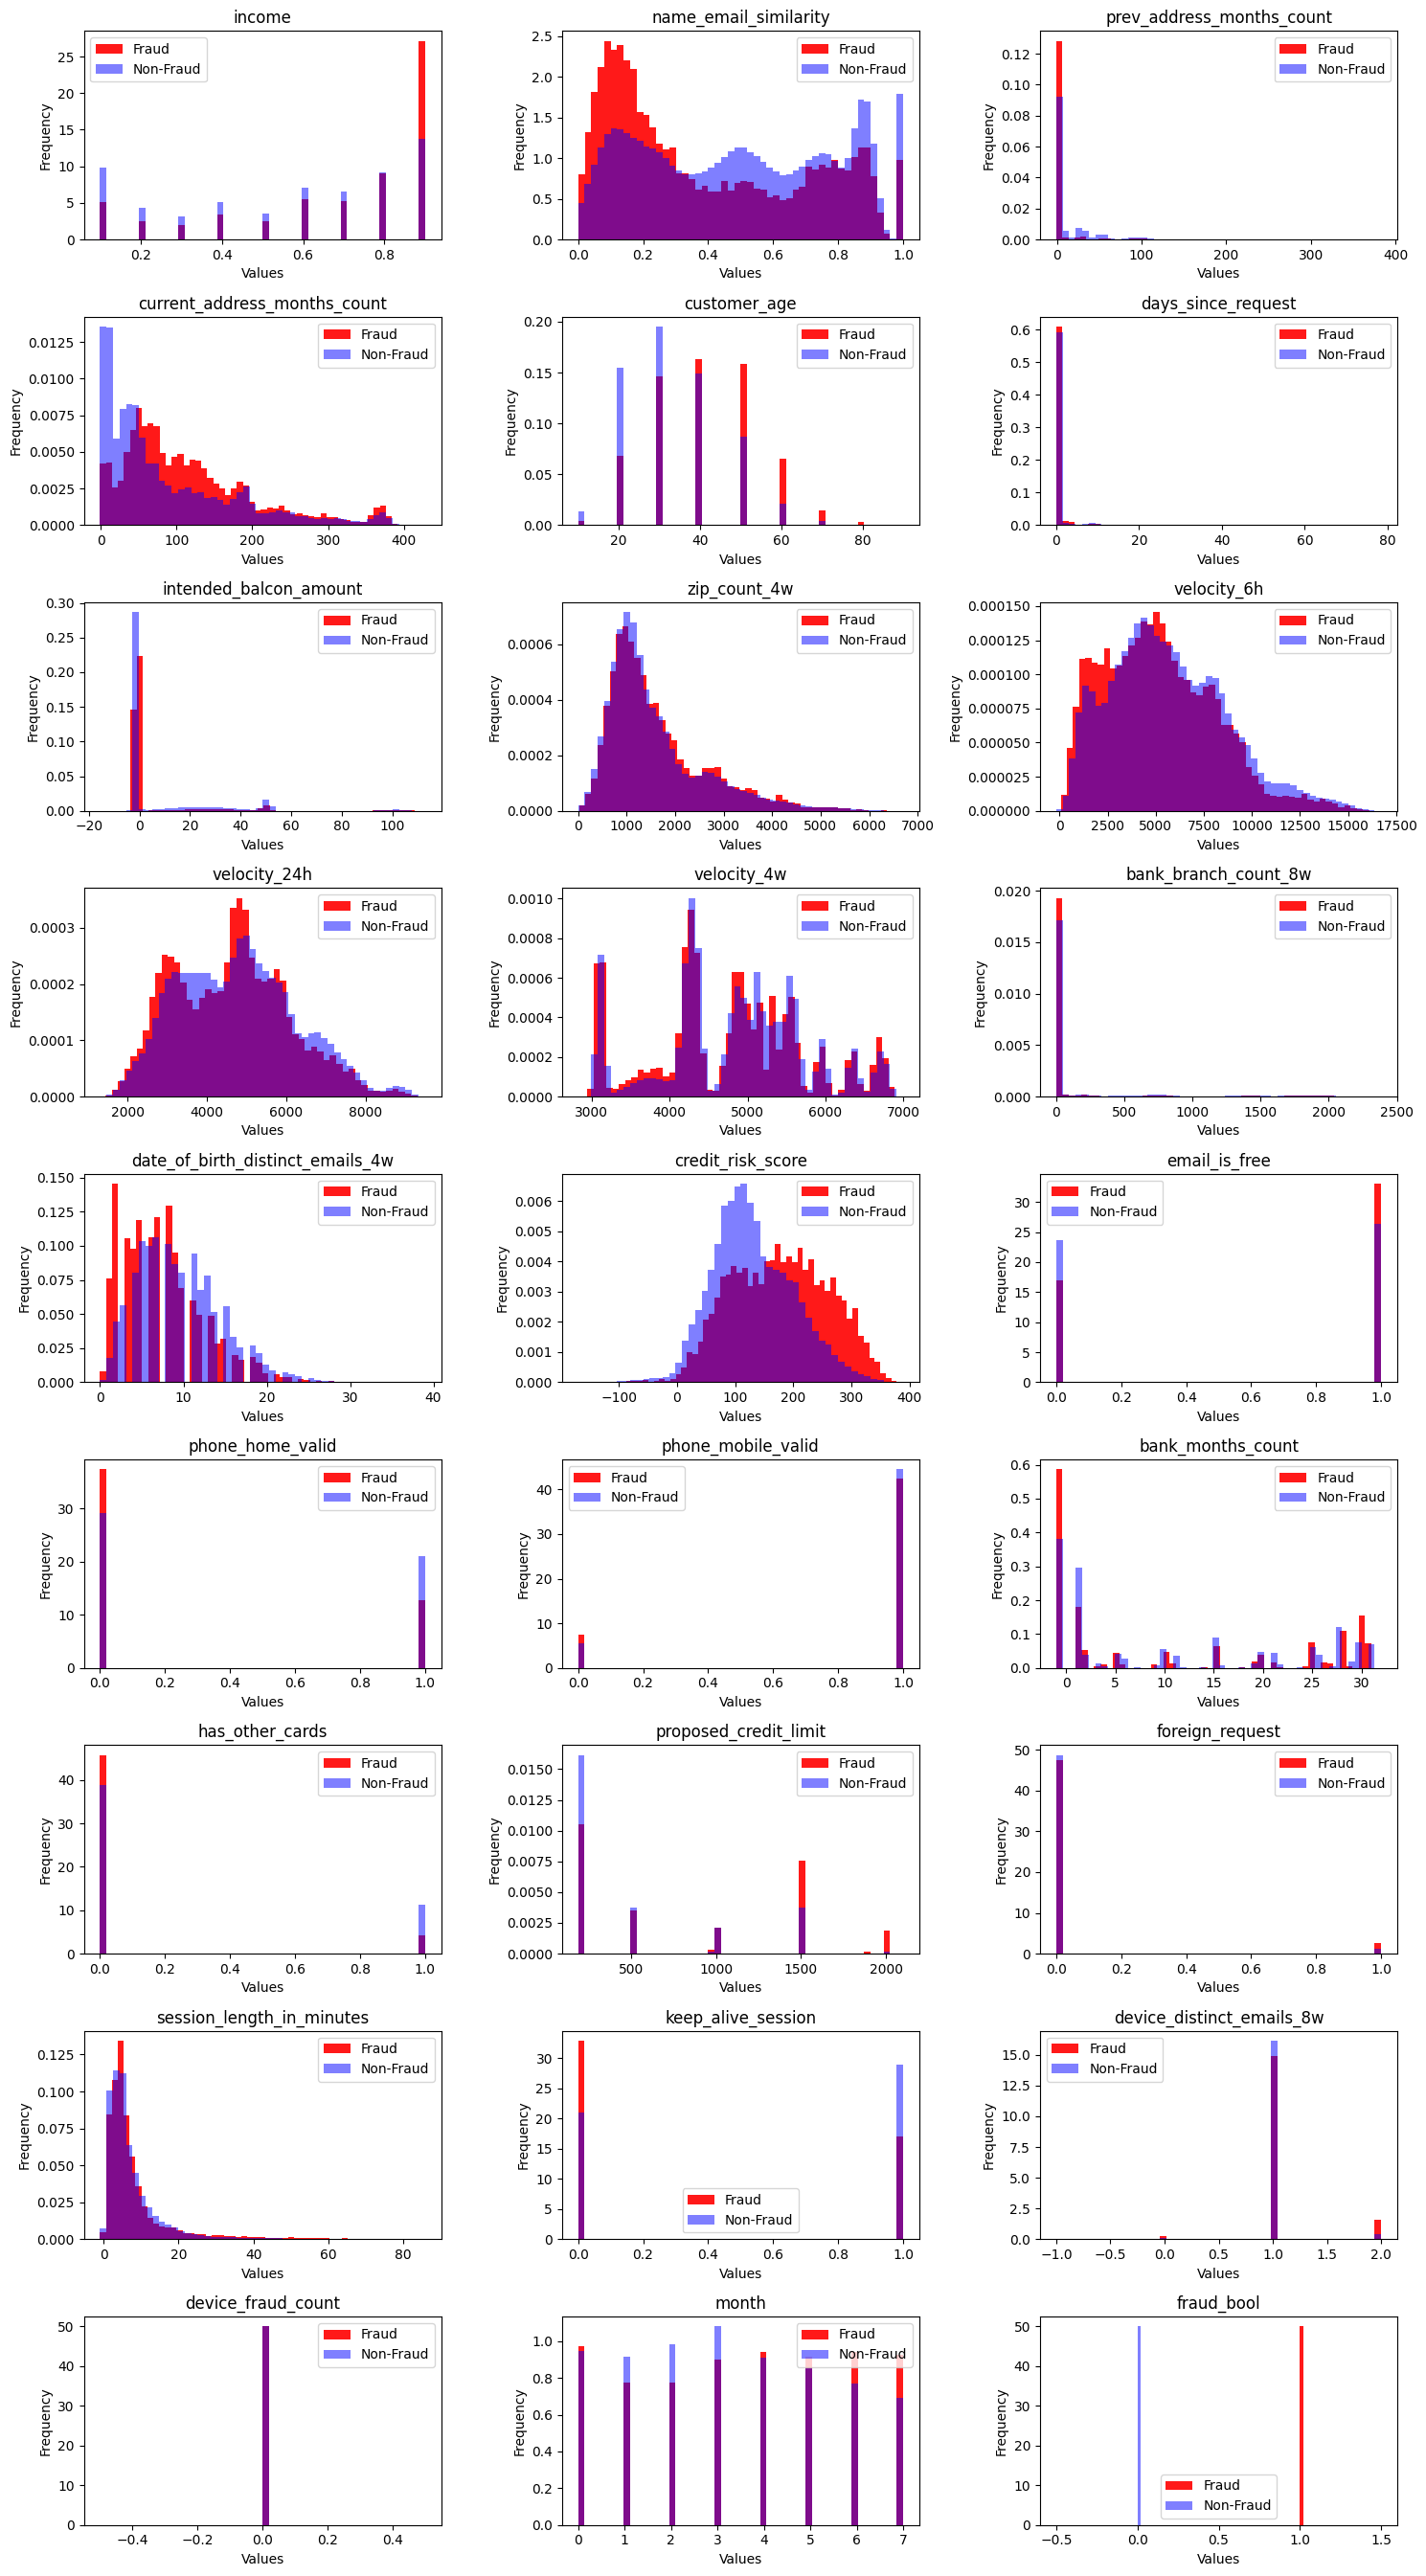

In [7]:
num_columns = len(non_categorical_fraud.columns)
num_columns = len(non_categorical_fraud.columns)
num_rows = (num_columns + 2) // 3

fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 3*num_rows))

for i, column in enumerate(non_categorical_fraud.columns):
    row_index = i // 3
    col_index = i % 3
    ax = axes[row_index, col_index]
    
    # Plot histogram for fraud data
    ax.hist(non_categorical_fraud[column], bins=50, alpha=0.9, label='Fraud', color='red', density=True)
    
    # Plot histogram for non-fraud data
    ax.hist(non_categorical_real[column], bins=50, alpha=0.5, label='Non-Fraud', color='blue', density=True)
    
    # Set title and labels
    ax.set_title(column)
    ax.set_xlabel('Values')
    ax.set_ylabel('Frequency')
    
    # Add legend
    ax.legend()

# Remove any unused subplots
for i in range(num_columns, num_rows*3):
    fig.delaxes(axes[i // 3, i % 3])

plt.tight_layout()
plt.show()

### Feature importance

Trying to identify significant features using:

+ Random Forest
+ Gradient Boosting
+ Lasso

In [8]:
df_label = df['fraud_bool']

# Split data into numerical and categorical
df_cat = df.drop(columns='fraud_bool').select_dtypes(include=['category'])
df_num = df.drop(columns='fraud_bool').select_dtypes(exclude=['category'])

# One hot encoding for categorical data
df_cat_hot = pd.get_dummies(df_cat)

# combine numerical and one hot encoded categorical data
dff = pd.concat([df_num, df_cat_hot], axis=1)

#### Running on full dataset

In [9]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import Lasso

# Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(dff, df_label)
rf_feature_importances = rf_model.feature_importances_



# Gradient Boosting model
gbm_model = GradientBoostingClassifier()
gbm_model.fit(dff, df_label)
gbm_feature_importances = gbm_model.feature_importances_



# Lasso regression model
lasso_model = Lasso(alpha=0.1) 
lasso_model.fit(dff, df_label)
lasso_coefficients = lasso_model.coef_

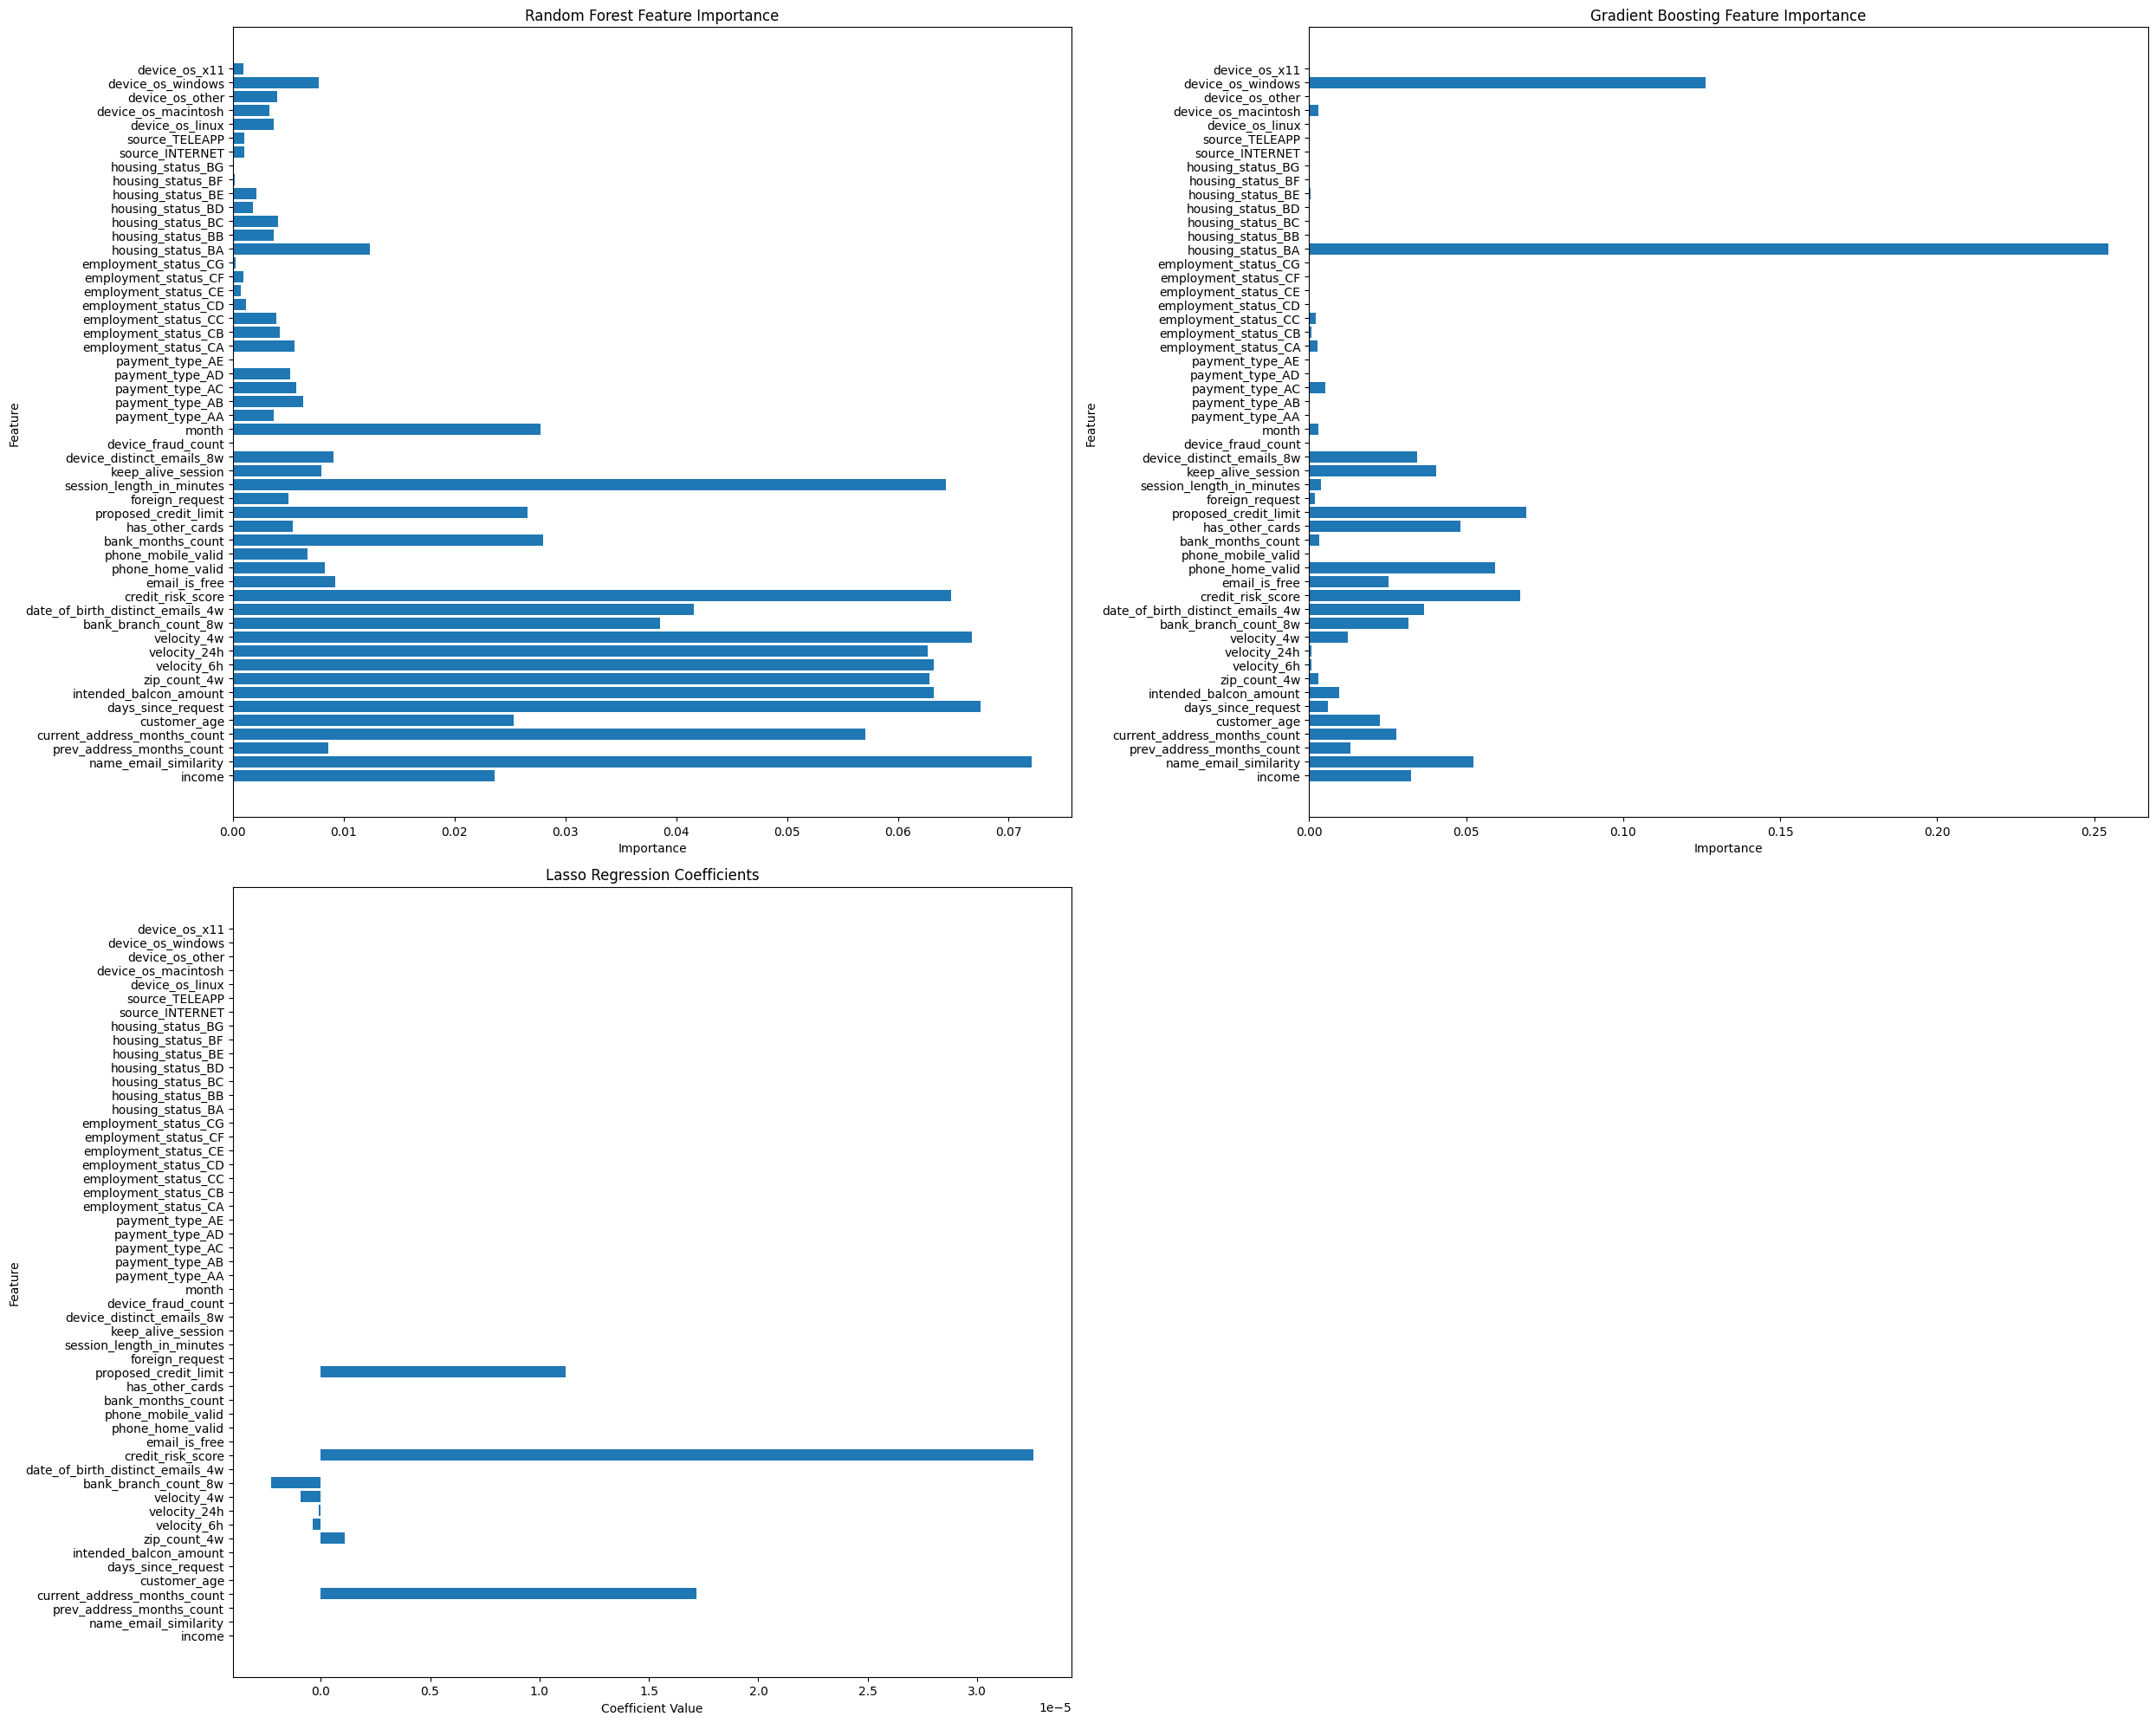

In [10]:
# Visualize feature importances
plt.figure(figsize=(25, 20))

plt.subplot(2, 2, 1)
plt.barh(range(len(rf_feature_importances)), rf_feature_importances, tick_label=dff.columns)
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.subplot(2, 2, 2)
plt.barh(range(len(gbm_feature_importances)), gbm_feature_importances, tick_label=dff.columns)
plt.title('Gradient Boosting Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.subplot(2, 2, 3)
plt.barh(range(len(lasso_coefficients)), lasso_coefficients, tick_label=dff.columns)
plt.title('Lasso Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')

plt.tight_layout()
plt.show()

### Running on undersampled dataset (Fraud 1:5 Non-Fraud)

In [11]:
# re-combine labels
combined_df = pd.concat([dff, df_label], axis=1)

# separate fraud and non-fraud data
fraud = combined_df[combined_df['fraud_bool'] == 1]
not_fraud = combined_df[combined_df['fraud_bool'] == 0]

# Randomly sample non-fraud data to create a balanced dataset
undersampled_not_fraud = not_fraud.sample(n=len(fraud)*5, random_state=42)

# Combine fraud and undersampled non-fraud data
downsize_dff = pd.concat([fraud, undersampled_not_fraud], axis=0).drop(columns='fraud_bool')
downsize_df_label = pd.concat([fraud, undersampled_not_fraud], axis=0)['fraud_bool']

Check on distribution of undersampled data to ensure non-biased undersampling

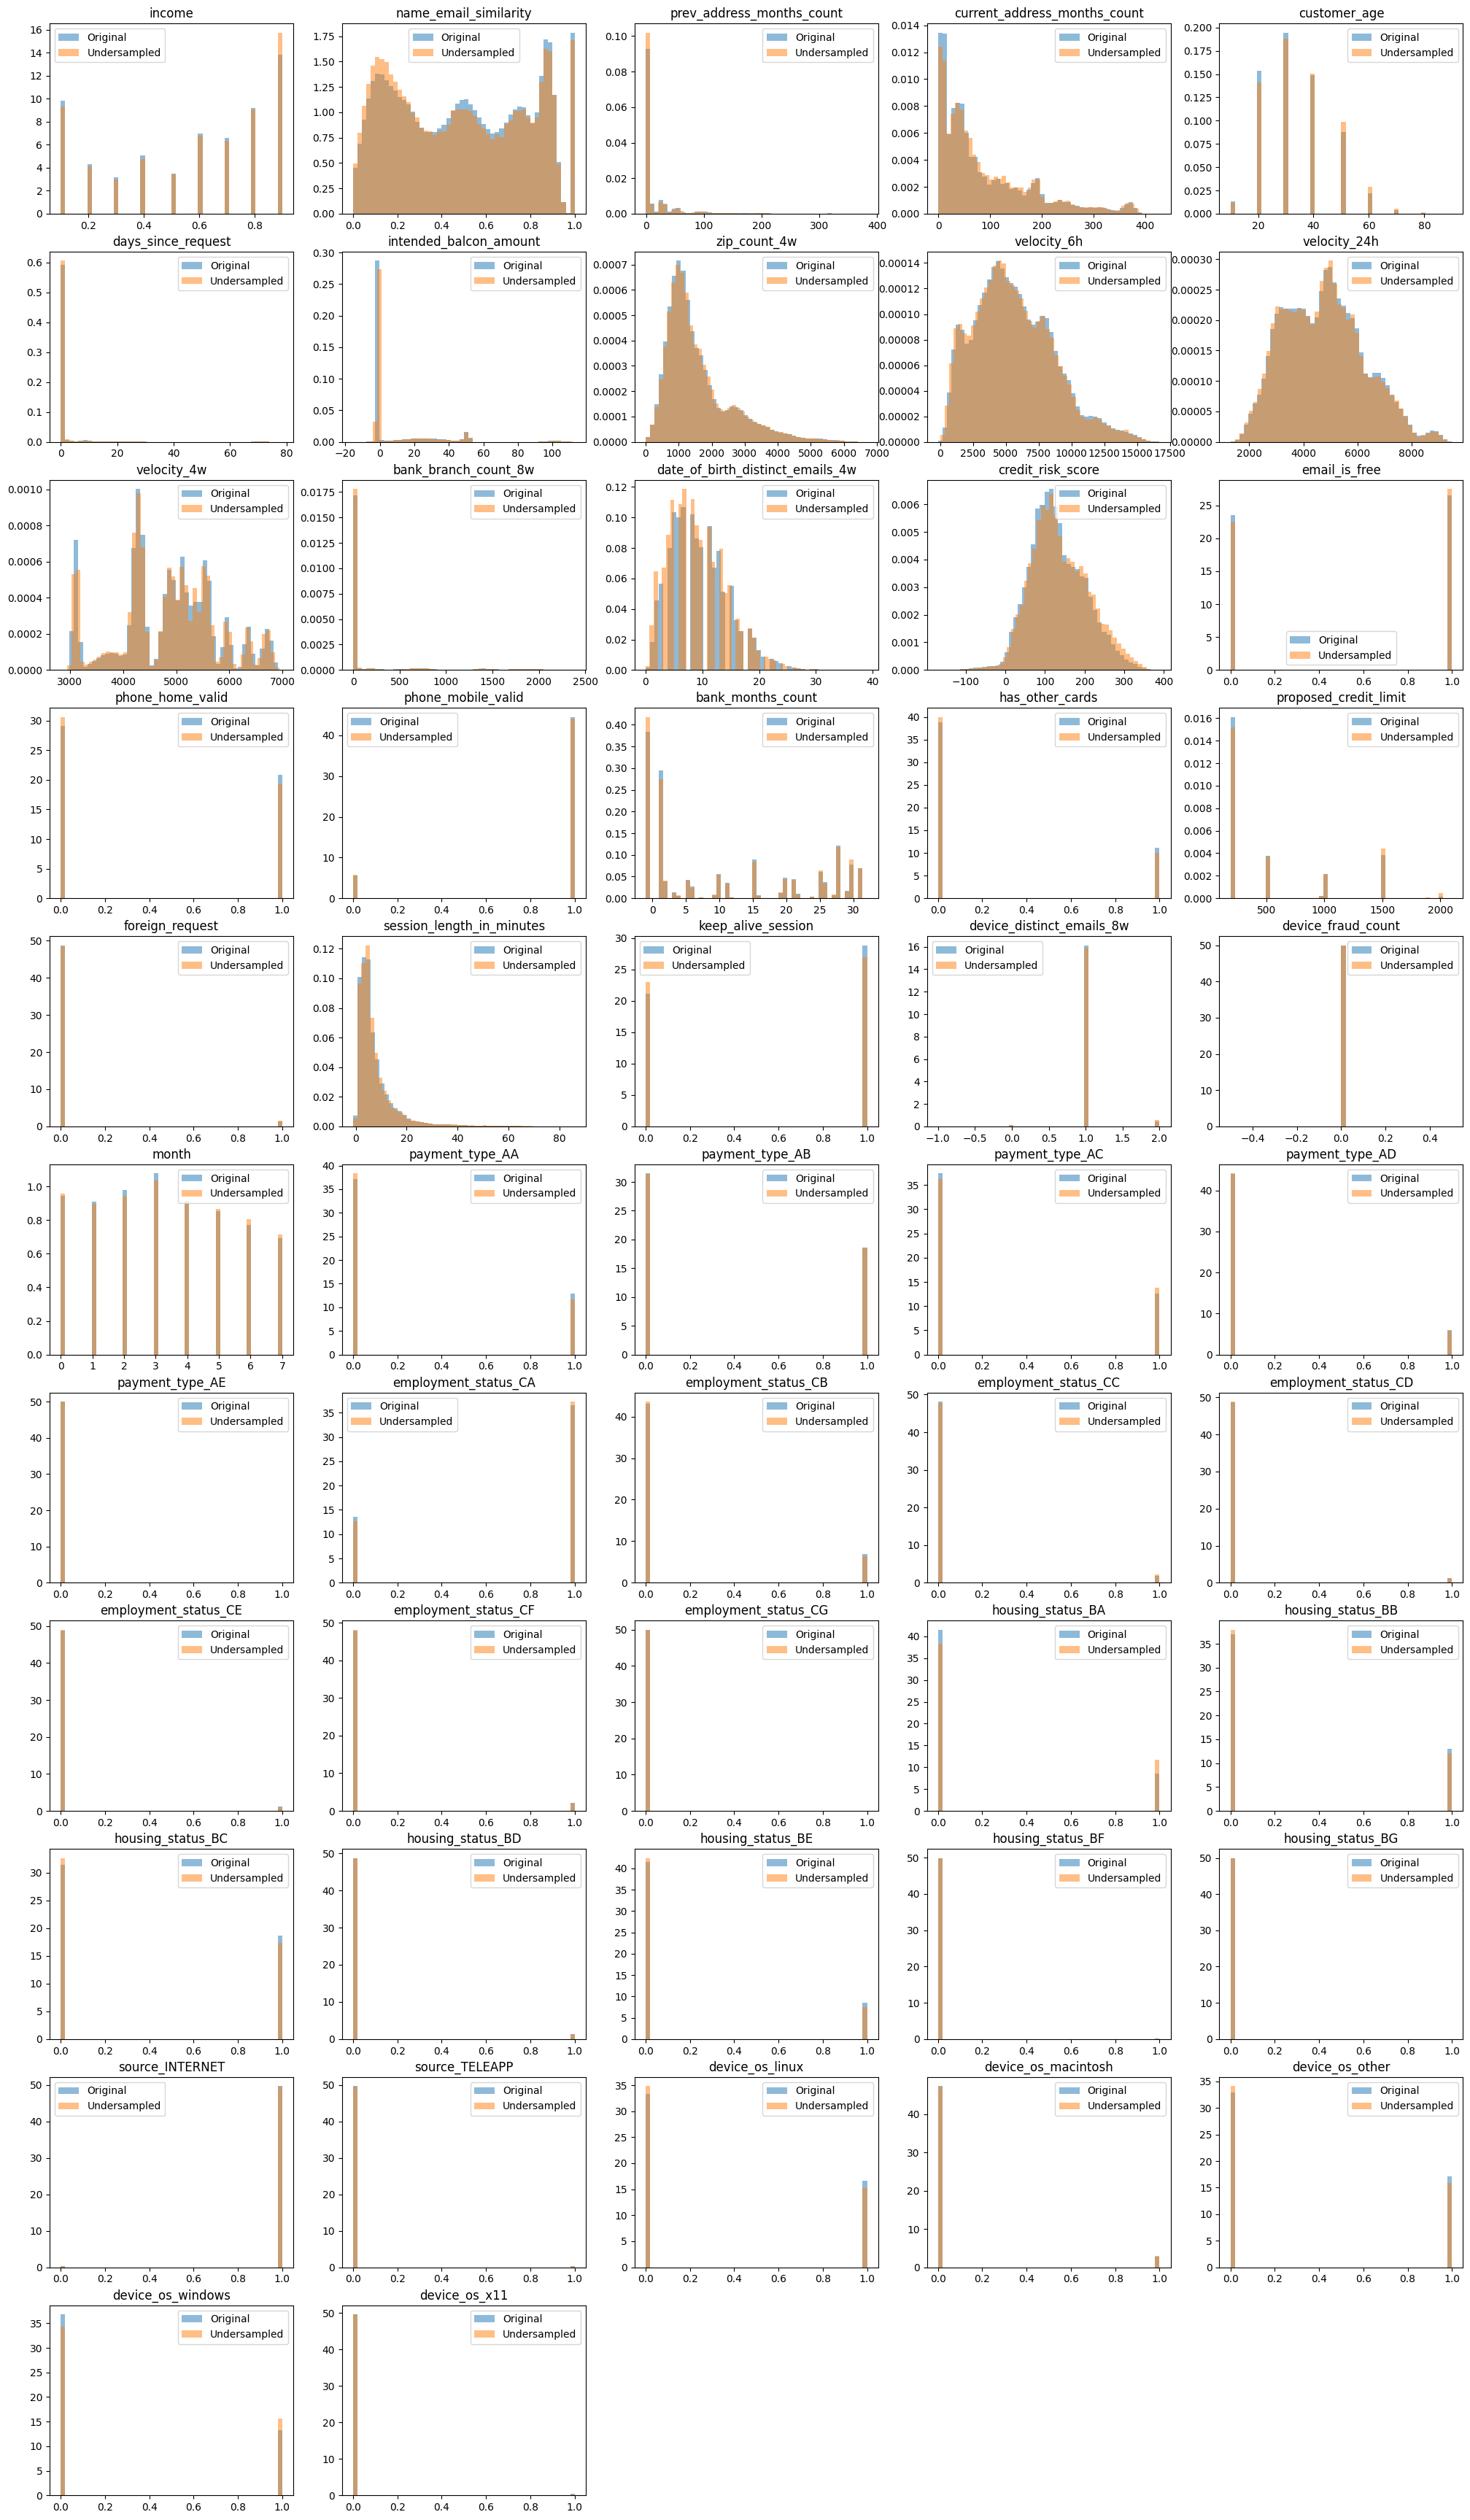

In [12]:
# Check distribution 
plt.figure(figsize=(25, 4 * ((len(downsize_dff.columns) // 5 ) + 1)))

for i, col in enumerate(downsize_dff.columns):
    plt.subplot(((len(downsize_dff.columns) // 5 ) + 1) , 5, i+1)
    plt.hist(dff[col], bins=50, alpha=0.5, label='Original', density=True)
    plt.hist(downsize_dff[col], bins=50, alpha=0.5, label='Undersampled', density=True)
    plt.title(col)
    plt.legend()

In [13]:
# Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(downsize_dff, downsize_df_label)
rf_feature_importances = rf_model.feature_importances_



# Gradient Boosting model
gbm_model = GradientBoostingClassifier()
gbm_model.fit(downsize_dff, downsize_df_label)
gbm_feature_importances = gbm_model.feature_importances_



# Lasso regression model
lasso_model = Lasso(alpha=0.1) 
lasso_model.fit(downsize_dff, downsize_df_label)
lasso_coefficients = lasso_model.coef_

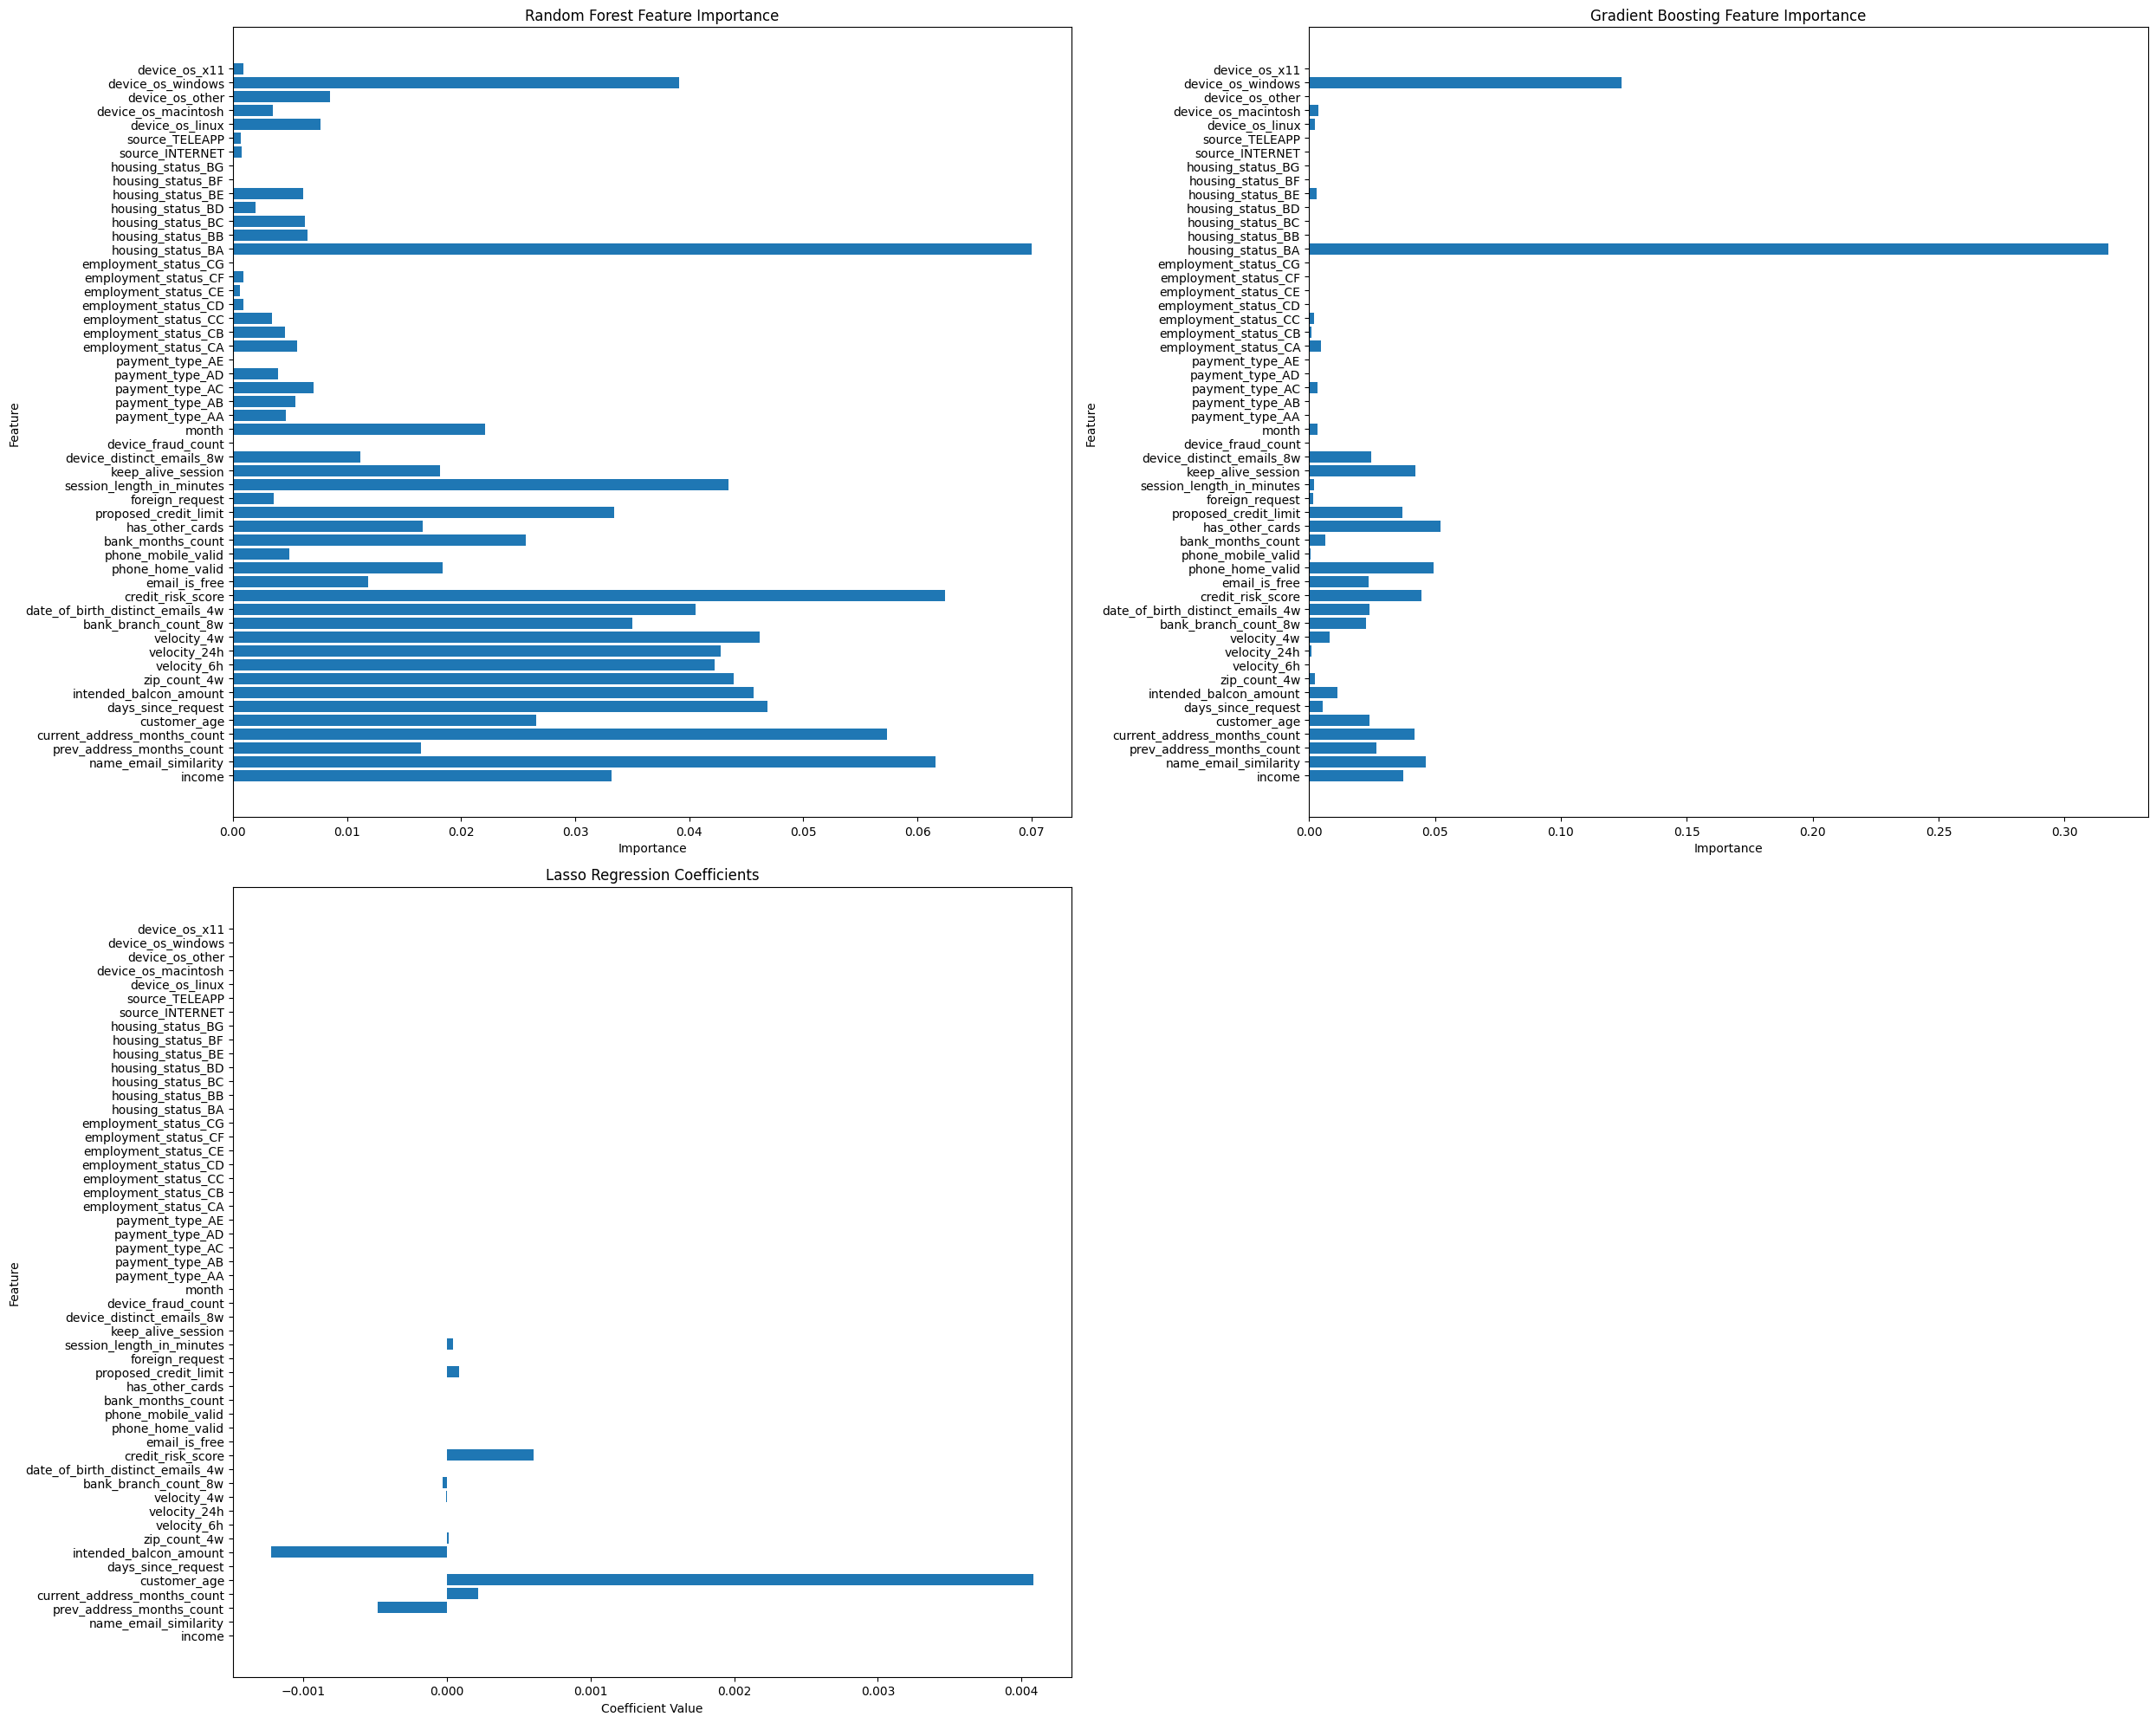

In [14]:
# Visualize feature importances
plt.figure(figsize=(25, 20))

plt.subplot(2, 2, 1)
plt.barh(range(len(rf_feature_importances)), rf_feature_importances, tick_label=downsize_dff.columns)
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.subplot(2, 2, 2)
plt.barh(range(len(gbm_feature_importances)), gbm_feature_importances, tick_label=downsize_dff.columns)
plt.title('Gradient Boosting Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.subplot(2, 2, 3)
plt.barh(range(len(lasso_coefficients)), lasso_coefficients, tick_label=downsize_dff.columns)
plt.title('Lasso Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')

plt.tight_layout()
plt.show()

### Running on undersampled dataset (Fraud 1:1 Non-Fraud)

In [15]:
# re-combine labels
combined_df = pd.concat([dff, df_label], axis=1)

# separate fraud and non-fraud data
fraud = combined_df[combined_df['fraud_bool'] == 1]
not_fraud = combined_df[combined_df['fraud_bool'] == 0]

# Randomly sample non-fraud data to create a balanced dataset
undersampled_not_fraud = not_fraud.sample(n=len(fraud), random_state=42)

# Combine fraud and undersampled non-fraud data
downsize_dff = pd.concat([fraud, undersampled_not_fraud], axis=0).drop(columns='fraud_bool')
downsize_df_label = pd.concat([fraud, undersampled_not_fraud], axis=0)['fraud_bool']

Check on distribution of undersampled data to ensure non-biased undersampling

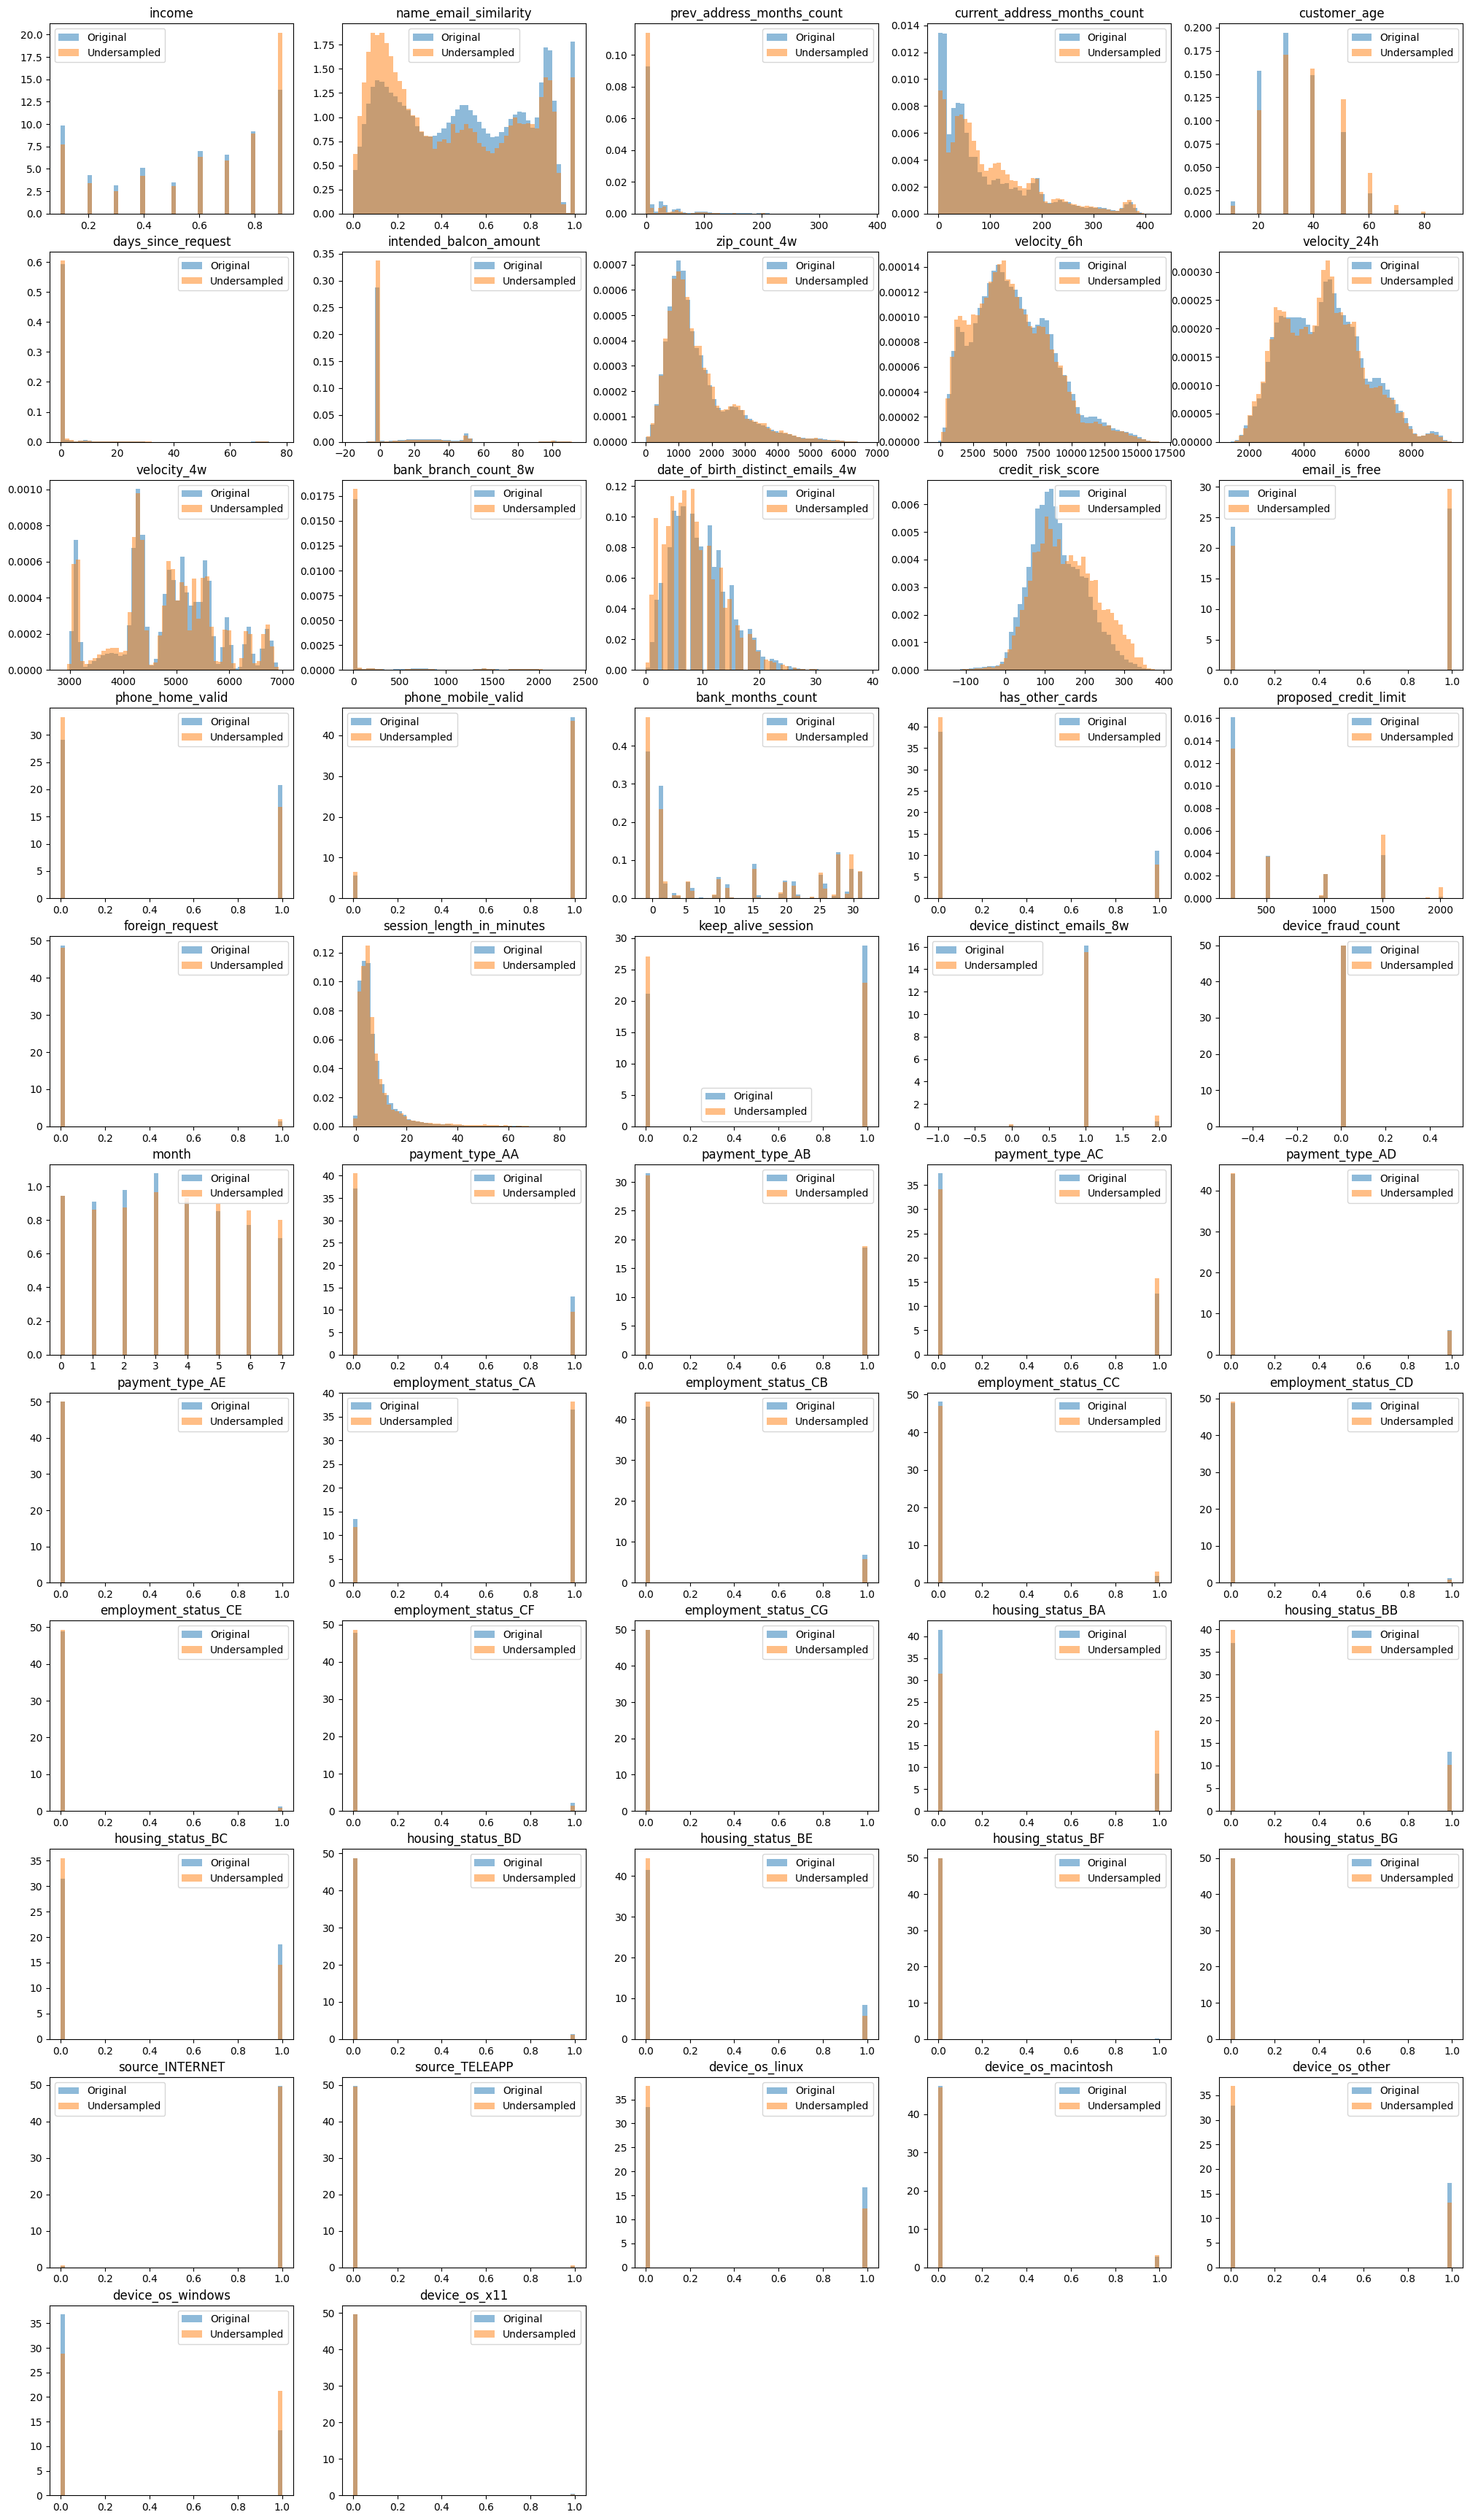

In [16]:
# Check distribution 
plt.figure(figsize=(25, 4 * ((len(downsize_dff.columns) // 5 ) + 1)))

for i, col in enumerate(downsize_dff.columns):
    plt.subplot(((len(downsize_dff.columns) // 5 ) + 1) , 5, i+1)
    plt.hist(dff[col], bins=50, alpha=0.5, label='Original', density=True)
    plt.hist(downsize_dff[col], bins=50, alpha=0.5, label='Undersampled', density=True)
    plt.title(col)
    plt.legend()

In [17]:
# Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(downsize_dff, downsize_df_label)
rf_feature_importances = rf_model.feature_importances_



# Gradient Boosting model
gbm_model = GradientBoostingClassifier()
gbm_model.fit(downsize_dff, downsize_df_label)
gbm_feature_importances = gbm_model.feature_importances_



# Lasso regression model
lasso_model = Lasso(alpha=0.1) 
lasso_model.fit(downsize_dff, downsize_df_label)
lasso_coefficients = lasso_model.coef_

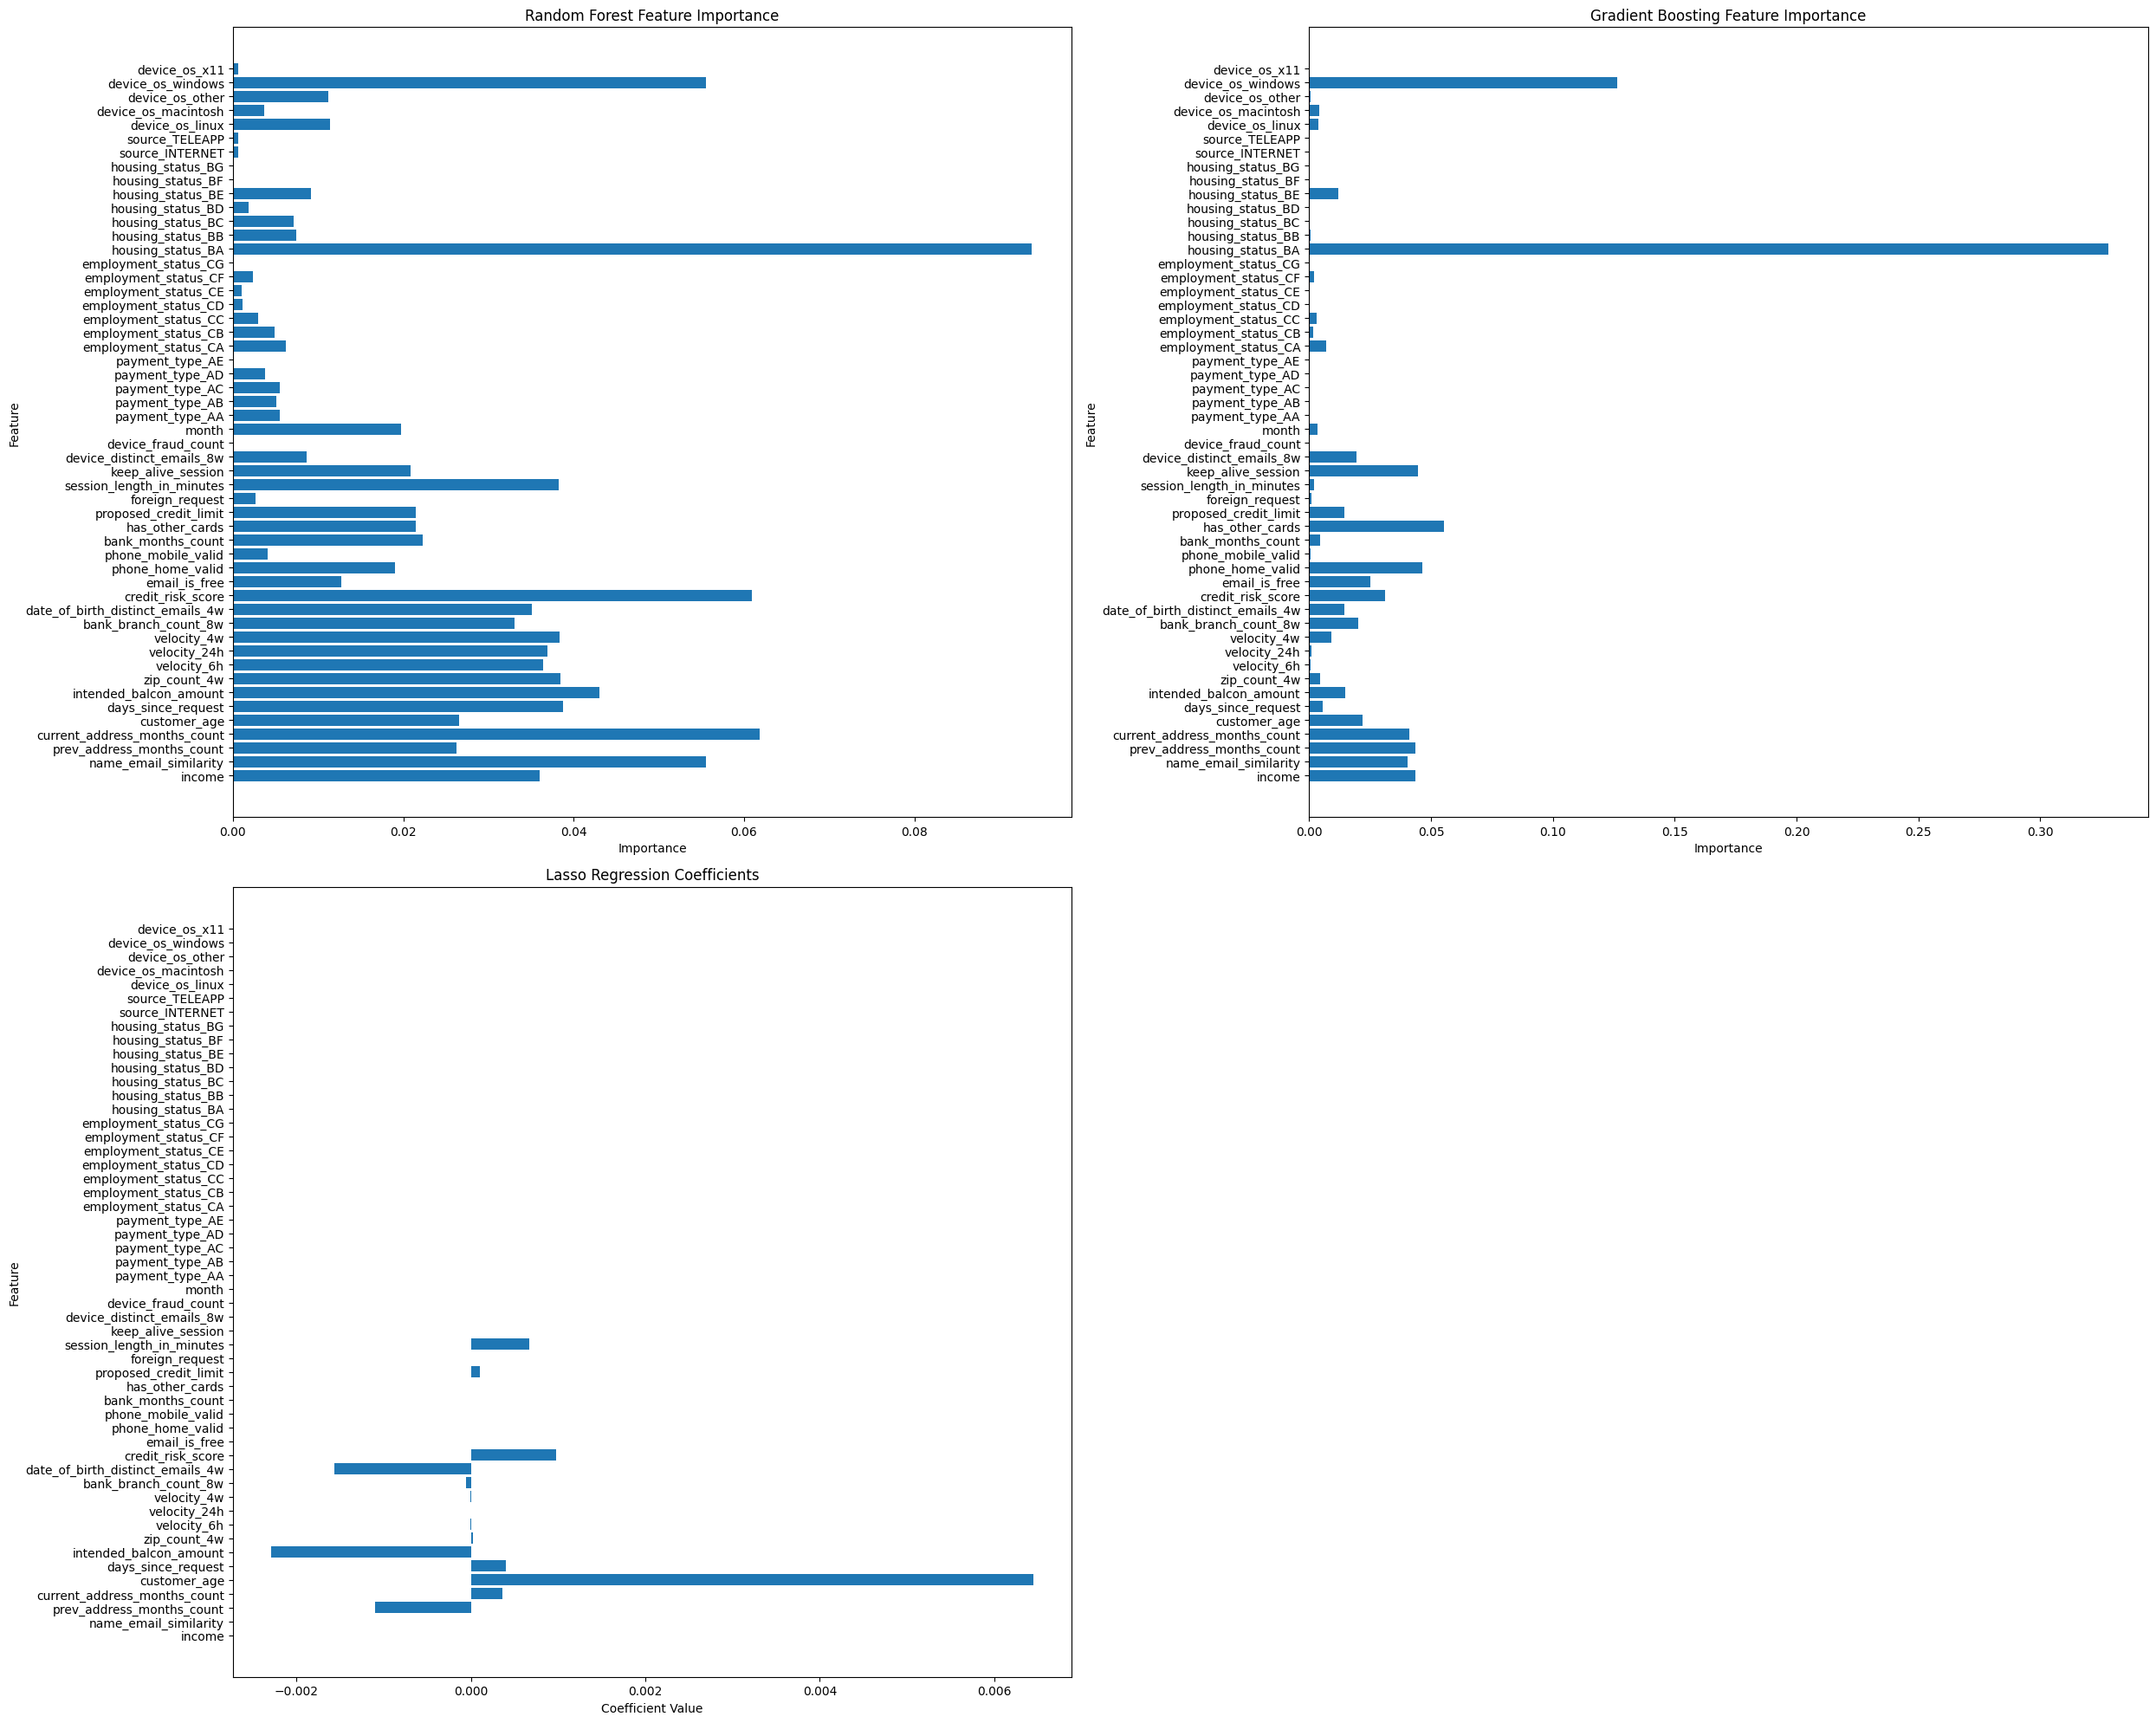

In [18]:
# Visualize feature importances
plt.figure(figsize=(25, 20))

plt.subplot(2, 2, 1)
plt.barh(range(len(rf_feature_importances)), rf_feature_importances, tick_label=downsize_dff.columns)
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.subplot(2, 2, 2)
plt.barh(range(len(gbm_feature_importances)), gbm_feature_importances, tick_label=downsize_dff.columns)
plt.title('Gradient Boosting Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.subplot(2, 2, 3)
plt.barh(range(len(lasso_coefficients)), lasso_coefficients, tick_label=downsize_dff.columns)
plt.title('Lasso Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')

plt.tight_layout()
plt.show()